TP Camera calibration, triangulation, relative orientation
===========

1. Projection functions: image to world coordinates
2. 3D bundle intersection (triangulation)
3. Essential matrix & relative orientation
-------------------------------------

Install dependencies
---------------------------

In [1]:
import os
from os.path import exists, join, basename, splitext
import numpy as np
from scipy.optimize import minimize
from scipy.linalg import svd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
YOUR_PATH = '/content/drive/MyDrive/Master 2 - VMI/Imagerie 3D/'
%cd $YOUR_PATH
!pwd

%cd $YOUR_PATH"P5/"
!pwd
!pip3 install --force-reinstall *.whl

/content/drive/MyDrive/Master 2 - VMI/Imagerie 3D
/content/drive/MyDrive/Master 2 - VMI/Imagerie 3D
/content/drive/MyDrive/Master 2 - VMI/Imagerie 3D/P5
/content/drive/MyDrive/Master 2 - VMI/Imagerie 3D/P5
Processing ./MMVII-0.0.2-cp310-cp310-linux_x86_64.whl


Get data
--------

In [3]:
import MMVII
from MMVII import *

dirData = YOUR_PATH + 'P5/Saisies-MMV1'

im1name = 'IMGP4167.JPG'
im2name = 'IMGP4168.JPG'
im3name = 'IMGP4169.JPG'
im4name = 'IMGP4170.JPG'

# Read image points
pts2D = {
    im1name : SetMesPtOf1Im.fromFile(dirData + '/Saisies_MMVII/MesIm-' + im1name + '.xml'),
    im2name : SetMesPtOf1Im.fromFile(dirData + '/Saisies_MMVII/MesIm-' + im2name + '.xml'),
    im3name : SetMesPtOf1Im.fromFile(dirData + '/Saisies_MMVII/MesIm-' + im3name + '.xml'),
    im4name : SetMesPtOf1Im.fromFile(dirData + '/Saisies_MMVII/MesIm-' + im4name + '.xml')
}

# Read 3D world coordinates corresponding to image points
pts3D = SetMesGCP.fromFile(dirData + '/Saisies_MMVII/MesGCP_Ground-Pts3D.xml')

for pt3D in pts3D.measures() :
  print(pt3D.namePt,pt3D.pt)

# Read extrinsic parameters
extrinsics = {
    im1name : SensorCamPC.fromFile(dirData + '/Ori-Ground-MMVII/Ori-PerspCentral-' + im1name + '.xml'),
    im2name : SensorCamPC.fromFile(dirData + '/Ori-Ground-MMVII/Ori-PerspCentral-' + im2name + '.xml'),
    im3name : SensorCamPC.fromFile(dirData + '/Ori-Ground-MMVII/Ori-PerspCentral-' + im3name + '.xml'),
    im4name : SensorCamPC.fromFile(dirData + '/Ori-Ground-MMVII/Ori-PerspCentral-' + im4name + '.xml')
}

# Read intrinsic parameters (camera calibration + distortions)
calib = PerspCamIntrCalib.fromFile(dirData + '/Ori-Ground-MMVII/Calib-PerspCentral-Foc-28000_Cam-PENTAX_K5.xml')


MMVII path: /usr/local/MMVII/MMVII
Stone-1 Pt3dr(0.182895665614618,-3.78002060469805,2.56022810571964)
Stone-2 Pt3dr(0.234792215591027,-5.36333800580975,2.42659720440635)
Stone-3 Pt3dr(0.194213046998493,-4.82293063921051,1.7537725591411)
I-of-I Pt3dr(0.754045221758524,0.496427193197003,0.431416432371162)
Acute Pt3dr(0.898750585424819,1.10409507249266,0.444680581722014)
Finger-1 Pt3dr(1.31771333753879,0.989188464947305,0.370627429238322)
Stone-6 Pt3dr(0.150697933447584,1.10818337179322,0.773464897817899)
Stone-7 Pt3dr(0.256396378205514,2.35318759021626,2.23887785258234)
Grille Pt3dr(1.40207519252832,2.19454588983995,0.403829859842775)


### Manipulate data structures

In [4]:
# interactive exercise with students

# pts2D
print(pts2D[im1name].measures()[0])
print(pts2D[im1name].measures()[0].pt)
print(pts2D[im1name].measures()[0].namePt)
#help(pts2D[im1name].measures()[0])

# pts3D
print('Pts 3D', pts3D.measures()[0])
print('Pts 3D', pts3D.measures()[0].pt)

# extrinsics orientation
print(extrinsics[im1name].center)
#help(extrinsics[im1name].pose)
print(extrinsics[im1name].pose.tr)
print(extrinsics[im1name].pose.rot)
print(extrinsics[im1name].pose.rot.array())

# calib
print(calib.f, calib.pp, calib.szPix)
print(calib.vParamDist())

MesIm1Pt Stone-6 [644.28631,232.68332], sigma2 (xx,xy,yy): 1, 0, 1)
Pt2dr(644.286307996219,232.68331645072)
Stone-6
Pts 3D Mes1GCP Stone-1 [0.18289567,-3.7800206,2.5602281], sigma2 (XX,YY,ZZ): (1, 1, 1)
Pts 3D Pt3dr(0.182895665614618,-3.78002060469805,2.56022810571964)
Pt3dr(5.20448828567061,1.49496779535545,2.11770763380632)
Pt3dr(5.20448828567061,1.49496779535545,2.11770763380632)
Rotation3D([[-0.162381354909888,0.097033570441216,-0.981945406723336],[0.038317790121003,0.995022468273721,0.091989317807644],[0.985983794257224,-0.022688627942267,-0.165291208550926]])
[[-0.16238135  0.09703357 -0.98194541]
 [ 0.03831779  0.99502247  0.09198932]
 [ 0.98598379 -0.02268863 -0.16529121]]
2112.194961341226 Pt2dr(856.866902730829,577.613558771481) Pt2di(1728,1152)
[-0.099311884161592, 0.105599456943292, 0.035385127051667, -8.923787e-08, 9.6643093e-08, -8.96399711e-07, 1.5373804e-08]


# World $→$ image projection

**The task is to project a 3D point (apply extrinsic orientation) and apply camera parameters (distortions and camera calibration, aka intrinsic calibration)**.

$$(i, j) = \mathfrak{J} \left[ \mathfrak{D}  \left[ {\pi} \left(Pose (p) \right) \right]\right] $$


It consists of the following consecutive transformations:
1. $Pose = \{ R, C \}$ : Transform from world to camera frame

$$  Pose(P) = R^T \cdot (P - C) $$

2. $\pi$ : Transform point in camera frame to a bundle (direction)

$$ \pi \begin{pmatrix} x \\ y \\ z \end{pmatrix} = \begin{pmatrix} x/z \\ y/z \\ 1 \end{pmatrix} =  \vec{u} $$

3. $ \mathfrak{D} $ : Apply direct distortion

$$ D(\vec{u}) = \vec{u} (1 + k_2 \rho^2 + k_4 \rho^4 + \cdots ) = \vec{u_{dist}} $$

4. $ \mathfrak{J} = \{ pp_x, pp_y, F \}$ : Apply direct camera calibration, i.e., transform the *distorted* bundle in camera coordinates to a point in pixel coordinates


$$ \mathfrak{J}(\vec{u_{dist}}) =  \begin{pmatrix} \vec{u_{dist}}_x \cdot F + pp_x \\ \vec{u_{dist}}_y \cdot F + pp_y  \end{pmatrix} $$




where $(pp_x,pp_y)$ is the principal point, $F$ is the focal length



### Manipulation of camera orientation parameters

In [5]:
# interactive exercise with students
help(MMVII)

Help on module MMVII:

NAME
    MMVII

FUNCTIONS
    infEq(...) method of builtins.PyCapsule instance
        infEq(*args, **kwargs)
        Overloaded function.
        
        1. infEq(pt1: _MMVII.Pt1di, pt2: _MMVII.Pt1di) -> bool
        
        2. infEq(pt1: _MMVII.Pt2di, pt2: _MMVII.Pt2di) -> bool
        
        3. infEq(pt1: _MMVII.Pt3di, pt2: _MMVII.Pt3di) -> bool
        
        4. infEq(pt1: _MMVII.Pt1df, pt2: _MMVII.Pt1df) -> bool
        
        5. infEq(pt1: _MMVII.Pt2df, pt2: _MMVII.Pt2df) -> bool
        
        6. infEq(pt1: _MMVII.Pt3df, pt2: _MMVII.Pt3df) -> bool
        
        7. infEq(pt1: _MMVII.Pt1dr, pt2: _MMVII.Pt1dr) -> bool
        
        8. infEq(pt1: _MMVII.Pt2dr, pt2: _MMVII.Pt2dr) -> bool
        
        9. infEq(pt1: _MMVII.Pt3dr, pt2: _MMVII.Pt3dr) -> bool
    
    infStr(...) method of builtins.PyCapsule instance
        infStr(*args, **kwargs)
        Overloaded function.
        
        1. infStr(pt1: _MMVII.Pt1di, pt2: _MMVII.Pt1di) -> bo

In [199]:
# TO-DO
def World2Camera(p: SensorCamPC, pt3d: tuple) -> tuple:
    R = p.pose.rot.array().transpose()
    C = p.center
    return R @ (pt3d - C)

# TO-DO
def Cam2Bundle(pt3d: tuple) -> tuple:
  return pt3d / pt3d[2]

# TO-DO
def RadDistOnBundle(coeffs: tuple, bundle: tuple) -> tuple:
    k2, k4, k6 = coeffs[0], coeffs[1], coeffs[2]
    ux, uy, uz = bundle
    r = np.sqrt(ux**2 + uy**2)
    distortion_factor = 1.0 + k2*r**2 + k4*r**4 + k6*r**6

    distorted_ux = ux * distortion_factor
    distorted_uy = uy * distortion_factor

    return (distorted_ux, distorted_uy, uz)


def DecDistOnBundle(coeffs: tuple, bundle: tuple) -> tuple:
  pass

# TO-DO
def Bundle2Pixel(calib: PerspCamIntrCalib, bundle: tuple) -> tuple:
  return [bundle[0] * calib.f + calib.pp[0], bundle[1] * calib.f + calib.pp[1]]

# TO-DO
def World2Pixel(calib: PerspCamIntrCalib, p: SensorCamPC, pt3d: tuple) -> tuple:
  return Bundle2Pixel(calib, RadDistOnBundle(calib.vParamDist(), Cam2Bundle(World2Camera(p, pt3d))))


In [200]:
# Max residual between your projected point and the true value
eps = 3.0
for pt3D in pts3D.measures() :

  for imName in extrinsics:
      if pts2D[imName].nameHasMeasure(pt3D.namePt) :
        pt2D = pts2D[imName].measuresOfName(pt3D.namePt)

        # world to camera frame
        pt_cam = World2Camera(extrinsics[imName], pt3D.pt)

        # camera frame to bundle
        pt_bun = Cam2Bundle(pt_cam)

        # bundle to pixel
        pixel = Bundle2Pixel(calib, pt_bun)

        # function that combines all the above stages
        world_pix = World2Pixel(calib, extrinsics[imName], pt3D.pt)

        # calculate residual
        #    i.e. distance between your projection of pt3D and the point in pt2D
        residual = np.linalg.norm(world_pix - np.array(pt2D.pt))
        print('Sucess for ',pt3D.namePt,' in ',imName,', res=',residual) if ( residual< eps ) else print('Failed for ',pt3D.namePt,' in ',imName , '=> Try harder, your point\'s reprojection is ', residual, 'away from the correct value')




Sucess for  I-of-I  in  IMGP4168.JPG , res= 1.5469345792491924
Sucess for  I-of-I  in  IMGP4169.JPG , res= 1.5771322240099785
Sucess for  I-of-I  in  IMGP4170.JPG , res= 0.4555891744673709
Sucess for  Acute  in  IMGP4168.JPG , res= 0.6235599385409393
Sucess for  Acute  in  IMGP4169.JPG , res= 0.5353649198284787
Sucess for  Acute  in  IMGP4170.JPG , res= 0.41847701824062217
Sucess for  Finger-1  in  IMGP4168.JPG , res= 1.3536198287599073
Sucess for  Finger-1  in  IMGP4169.JPG , res= 1.2175051416480056
Sucess for  Finger-1  in  IMGP4170.JPG , res= 2.3677543247273665
Sucess for  Stone-6  in  IMGP4167.JPG , res= 0.4135608537104416
Sucess for  Stone-6  in  IMGP4168.JPG , res= 0.9972883003112634
Sucess for  Stone-6  in  IMGP4169.JPG , res= 1.911509179412794
Sucess for  Stone-7  in  IMGP4167.JPG , res= 1.122842156184511
Sucess for  Stone-7  in  IMGP4168.JPG , res= 1.5850498157250499
Sucess for  Grille  in  IMGP4167.JPG , res= 2.885993571649906
Sucess for  Grille  in  IMGP4168.JPG , res= 1.020

# Image $→$ world projection

**The task is to apply camera parameters (inverse camera calibration and distortions) \& project to the world frame**.

$$ P =  Pose^{-1} \left[ \mathfrak{D}^{-1} \left(\mathfrak{J}^{-1} (i,j)\right)\right] $$

1. $\mathfrak{J}$ : Apply inverse camera calibration, i.e. transform pixels to bundles in camera frame

 $$ \mathfrak{J}^{-1}(i,j) =  \begin{pmatrix} \frac{i - pp_x}{F} \\ \frac{j - pp_y}{F} \\ 1 \end{pmatrix} = \vec{u} $$

where $(pp_x,pp_y)$ is the principal point, $F$ is the focal length and $D^{-1}$ is the inverse distortion.

2. $\mathfrak{D}^{-1}$ : Apply inverse camera distortions, i.e., *undistort* bundles

$$ D^{-1}(\vec{u}) = \vec{u} (1 + k_2 \rho^2 + k_4 \rho^4 + \cdots ) = \vec{u_{undist}} $$

3. $Pose^{-1}$ : Transform bundle to world frame

$$\vec{U}= R \cdot \vec{u_{undist}} + C$$




     

In [201]:
#TO-DO
# verify with MMVII using this function template calib.dirBundle(pt2d)
def Pixel2Bundle(calib: PerspCamIntrCalib, point: tuple) -> tuple:
    i, j = point
    F = calib.f
    ppx, ppy = calib.pp

    u = (i - ppx) / F
    v = (j - ppy) / F
    w = 1

    return (u, v, w)

#TO-DO
# verify with MMVII using this function template extrinsics[imName].pose.value(calib.dirBundle(pt2D.pt))
def Bundle2World(p: SensorCamPC, bundle: tuple) ->tuple:
  return p.pose.rot.array() @ np.array(bundle) + p.center

#TO-DO
# verify with MMVII using this function template  extrinsics[imName].imageAndDepth2Ground(Pt3dr(pt2D.pt.x,pt2D.pt.y,1.0))
def Pixel2World(p: SensorCamPC, calib: PerspCamIntrCalib, point: tuple) ->tuple:
  rad_coeff_inv = [-x for x in calib.vParamDist()]
  return Bundle2World(p, RadDistOnBundle(rad_coeff_inv, Pixel2Bundle(calib, point)))

## Test your functions

### without distortions

In [202]:
#TO-DO
#help(pts2D[im1name].measures()[0])

# choose an image and an image point
an_image = im1name
a_pt2d = pts2D[an_image].measures()[0].pt

# apply Pixel2Bundle
pt_bun = Pixel2Bundle(calib, a_pt2d)
print(pt_bun)
# verify with MMVII function
pt_bun_verify = calib.dirBundle(a_pt2d)
print(pt_bun_verify)
# compute residual
residual = np.linalg.norm(pt_bun - np.array(pt_bun_verify))
print(residual)

# apply Bundle2World
pt_wor = Bundle2World(extrinsics[an_image], pt_bun)
print(pt_wor)
# verify with MMVII function
pt_wor_verify = extrinsics[an_image].pose.value(calib.dirBundle(a_pt2d))
print(pt_wor_verify)
# compute residual
residual = np.linalg.norm(pt_wor - np.array(pt_wor_verify))
print(residual)

(-0.10064440007925379, -0.1633041687125954, 1)
Pt3dr(-0.101001381774181,-0.163883267777273,1)
0.0006802879222973274
[4.22303967 1.42060933 1.85688783]
Pt3dr(4.22304144155953,1.42001942980184,1.85654898611702)
0.0006802879222971491


###with distortions

1. Estimate an approximate inverse function
2. Find a least squares estimate of the inverse function

In [203]:
#TO-DO
# approximation of the inverse
rad_coeff_inv = [-x for x in calib.vParamDist()]
# * apply RadDistOnBundle with rad_coeff_inv
pi_wor = Pixel2World(extrinsics[an_image], calib, a_pt2d)
print(pi_wor)
# * verify with MMVII function
verify = extrinsics[an_image].imageAndDepth2Ground(Pt3dr(a_pt2d[0], a_pt2d[1], 1.0))

print(verify)
residual = np.linalg.norm(pi_wor - np.array(verify))
print(residual)

[4.22304141 1.4200255  1.85655255]
Pt3dr(4.22304144155953,1.42001942980184,1.85654898611702)
7.036843969561197e-06


# Triangulation (Intersection de faisceau)

 <center>
  <img src="https://drive.google.com/uc?id=1tZXZQeEloAPwEJrUdHKqaEBo5RVm6S2d" height=250pix;/>
  <br>
</center>

1. Transform an image point to a bundle in world frame $$R \cdot bundle + C = Bundle$$
2. Show decomposition of bundles in orthogonal base and explain the algorithm
3. Write intersection equations & solve for $Q$:
   * all points belonging to a bundle satisfy:
   $$ (Q-P_k) \cdot v_k = 0  $$
   $$ (Q-P_k) \cdot w_k = 0  $$
   * every bundle gives 2 equations, therefore, with x2 bundles (x4 observations) we can recover 3D coordinates of out point (x3 unknowns)

   $$ \sum_{k}^N  \left[ (Q-P_k) \cdot v_k \right]^2 + \left[ (Q-P_k) \cdot w_k \right]^2 =  (Q-P_k)^2 \cdot (v_k^2 + w_k^2) =0 .$$

Note that:
   $$ u_k^Tu_k + v_k^Tv_k + w_k^Tw_k = I ⇒ I -  u_k^Tu_k = v_k^Tv_k + w_k^Tw_k .$$

Therefore:
   $$ 0 =  (Q-P_k)^2 \cdot (I -  u_k^2),$$

re-organising and taking the derivative:
$$ \sum_{k}^N   (Q^TQ - 2Q^TP_k + P_k^2) \cdot (I -  u_k^Tu_k) $$

$$ ⇒ \sum_{k}^N  Q \cdot (I -  u_k^Tu_k) - 2P_K \cdot (I -  u_k^Tu_k) + C = 0, $$


so we have a linear system of equations $Ax=b$ where

$A=(I -  u_k^Tu_k)$ and $b=2P_K \cdot (I -  u_k^Tu_k)$



In [204]:
# Max residual between your triangulated 3D point and its true coordinates
eps3d = 0.1

resTotal=0.0
for pt3D in pts3D.measures() :

  NbObs=0

  # check how many images see the point
  for imName in extrinsics:
    if pts2D[imName].nameHasMeasure(pt3D.namePt) :
      NbObs+=1
      print("visible",imName,NbObs)

  if NbObs>1:
    A = []
    b = []

    for imName in extrinsics:
      if pts2D[imName].nameHasMeasure(pt3D.namePt) :
          pt2D = pts2D[imName].measuresOfName(pt3D.namePt)

          p0 = extrinsics[imName].center

          bundle_cam_frame = Pixel2Bundle(calib, pt2D.pt)
          bundle_undist = RadDistOnBundle(rad_coeff_inv, bundle_cam_frame)
          p1 = Bundle2World(extrinsics[imName], bundle_undist)

          uvec = (np.array(p1) - np.array(p0))
          uvec /= np.linalg.norm(uvec)

          I = np.eye(3)
          uu = np.outer(uvec, uvec)

          A.append(I - uu)
          b.append(np.dot(p0, I - uu))

    # Convert lists to numpy arrays
    A = np.vstack(A)
    b = np.hstack(b)
    print(A)
    print(b)

    Q, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)

    residual = np.linalg.norm(Q - pt3D.pt)
    resTotal += residual
    print(residual)
    print('Sucess for ',pt3D.namePt,', res=',residual) if ( residual< eps3d ) else print('Failed for ',pt3D.namePt, '. Try harder, your 3D intersection is', residual, 'away from the correct value')

print('Total res=',resTotal)

visible IMGP4168.JPG 1
visible IMGP4169.JPG 2
visible IMGP4170.JPG 3
[[ 0.12751431 -0.06047764 -0.32801962]
 [-0.06047764  0.9958079  -0.02273717]
 [-0.32801962 -0.02273717  0.87667778]
 [ 0.12761335  0.05569631 -0.32897737]
 [ 0.05569631  0.99644415  0.0210031 ]
 [-0.32897737  0.0210031   0.8759425 ]
 [ 0.15494546  0.15108397 -0.32880237]
 [ 0.15108397  0.97298829  0.05878528]
 [-0.32880237  0.05878528  0.87206624]]
[-0.07520915  0.43567018  0.11972029 -0.01701339  0.54440986  0.13728565
  0.05023148  0.62318334  0.15725153]
0.01783045257648695
Sucess for  I-of-I , res= 0.01783045257648695
visible IMGP4168.JPG 1
visible IMGP4169.JPG 2
visible IMGP4170.JPG 3
[[ 0.13314166  0.06119591 -0.33417064]
 [ 0.06119591  0.99567987  0.02359079]
 [-0.33417064  0.02359079  0.87117847]
 [ 0.16158958  0.17552141 -0.3235284 ]
 [ 0.17552141  0.96325455  0.06773074]
 [-0.3235284   0.06773074  0.87515587]
 [ 0.21208426  0.26082246 -0.31476368]
 [ 0.26082246  0.91366037  0.10419571]
 [-0.31476368  0.1041

# Essential matrix between im1name and im2name

$$ (x_1, y_1, 1) \cdot E \cdot (x_2, y_2, 1)^T = 0 $$


1. **Linear solution**: find the first approximation of the essential matrix $E_0$

The minimization function *ErrEssentialMatrix* will take all $N$ features into account, i.e.:
$$  \sum_{k=0}^{N-1} \left[ \begin{pmatrix} x_1 & y_1 & z_1  \end{pmatrix} \cdot
\begin{pmatrix} a & b & c \\
                d & e & f  \\
                g & h & 1.0 \end{pmatrix} \cdot
\begin{pmatrix} x_2 \\ y_2 \\ z_2  \end{pmatrix} \right]^2 = 0 $$

$$ ⇒   \sum_{k=0}^{N-1} \left( x_1 a x_2 + x_1 b y_2 + x_1 c z_2 + \\ y_1 d x_2 + y_1 e y_2 + y_1 f z_2 + \\ z_1 g x_2 + z_1 h y_2 + z_1  z_2 \right)^2 = 0$$






In [205]:
# function that imports features

def ImportHom(NameFile) :
    File=open(NameFile,'r')
    Result = []
    for LStr in File.readlines() :
        aLFloat = []
        for x in  LStr.split(" ") :
           aLFloat.append(float(x))
        x1,y1,x2,y2 = aLFloat[0:4]
        Result.append([[x1,y1],[x2,y2]])
    File.close()
    return Result

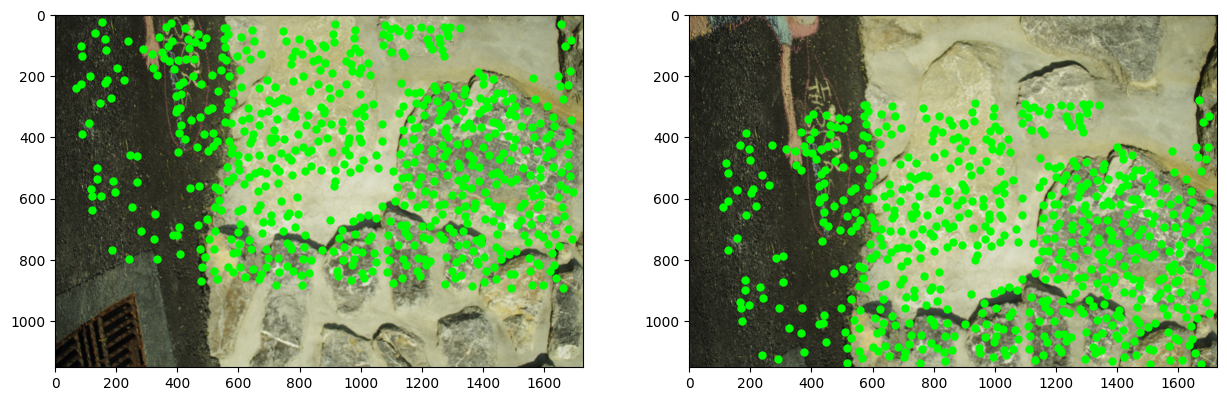

In [206]:
# read feature points
features = ImportHom(dirData + '/IMGP4167_IMGP4168.JPG.txt')
features=np.asarray(features,dtype=float)

# plot feature points
im1data = mpimg.imread(dirData + '/' + im1name)
im2data = mpimg.imread(dirData + '/' + im2name)

fig, ax = plt.subplots(1,2,figsize=[15, 15])

ax[0].imshow(im1data,cmap='gray')
ax[0].scatter(features[:,0,0], features[:,0,1], c='lime', linewidths=0)

ax[1].imshow(im2data,cmap='gray')
ax[1].scatter(features[:,1,0], features[:,1,1], c='lime', linewidths=0)

In [207]:
#TO-DO
def ErrEssentialMatrix(E0 : tuple, bundles : tuple) :
  a, b, c, d, e, f, g, h = E0
  resTotal = 0.0
  # iterate over all bundles & update resTotal
  for bundle in bundles:
    data_img1, data_img2 = bundle
    resTotal += (np.array([bundle[0][0], bundle[0][1], 1]) @ \
                 np.array([[a, b, c], [d, e, f], [g, h, 1]]) @ \
                 np.array([bundle[1][0], bundle[1][1], 1]))**2
  return resTotal


In [208]:
def triangulate(pk: tuple, u: tuple, A, b) :

  a00 = 1.0 - u[0]**2
  a11 = 1.0 - u[1]**2
  a22 = 1.0 - u[2]**2
  a10 = -u[0] * u[1]
  a20 = -u[0] * u[2]
  a21 = -u[1] * u[2]

  A[0,0] += a00
  A[1,1] += a11
  A[2,2] += a22

  A[1,0] += a10
  A[0,1] += a10

  A[2,0] += a20
  A[0,2] += a20

  A[1,2] += a21
  A[2,1] += a21

  b[0,0] += [a00, a10, a20] @ pk
  b[1,0] += [a10, a11, a21] @ pk
  b[2,0] += [a20, a21, a22] @ pk

In [209]:
#TO-DO
# transform image poits to bundle
bundles_im1im2_V = []

for pt1, pt2 in features:
    # pt1 et pt2 sont les paires de points d'image
    point1 = Pixel2Bundle(calib, pt1)
    point2 = Pixel2Bundle(calib, pt2)
    bundles_im1im2_V.append([point1, point2])


# inital values for E
Einit = [0,0,0,0,0,0,0,0]

#TO-DO
# write cost/residual function & minimize
E = minimize(ErrEssentialMatrix,Einit,bundles_im1im2_V)

print('Essential matrix residual, init= ', ErrEssentialMatrix(Einit, bundles_im1im2_V), ', final= ',ErrEssentialMatrix(E.x, bundles_im1im2_V))


Essential matrix residual, init=  647.0 , final=  0.37822795391988534


# Compute relative orientation from the essential matrix



*Defintion*: A $3x3$ matrix is an essential matrix if and only if two of its singular values are **equal** and the third one is zero.

*Explanation*: The essential matrix is a product of a skew-symmetric (translation) and an orthogonal matrix (rotation); a skew-symmetric matrix has always two equal singular values and one singular value of value $0$; multiplication by the rotation does not change the singular values;

 <center>
  <img src="https://drive.google.com/uc?id=1XHOmmT17WYTKF-DTbk_PEJDjWoTgdoAN" height=250pix;/>
  <br>
</center>

### Preliminaries:

We know that
  - the essential matrix is:
  $$ E = [\mathbf{t}]_{\times} R $$
  - any skew-symmetric matrix $S$ decomposes into
  $$S = k UZU^T$$
  - note the two special matrices:
  $$ Z = \begin{bmatrix}  0 & 1 & 0 \\ -1 & 0 & 0 \\ 0 & 0 & 0 \end{bmatrix} \quad and \quad W = \begin{bmatrix}  0 & -1 & 0 \\ 1 & 0 & 0 \\ 0 & 0 & 1 \end{bmatrix} $$
where $Z$ is skew-symmtric and $W$ is orthogonal.

<!--- - up to sign
  $$Z = diag(1,1,0)W$$
  - up to scale
  $$S = U \cdot diag(1,1,0)W \cdot U^T $$
  - **hence**
  $$ E = SR = U \cdot diag(1,1,0) \cdot (W  U^T  R)  \quad \rightarrow two \quad equal \quad sing.values$$
Beause the two singular values are equal, $SVD$ of $E$ is not unique. There is a one-parameter family of solutons to E. In fact, there is a solution for any rotation matrix $2x2$ :
$$ E = (U diag(R_{2x2},1)) \cdot diag(1,1,0) \cdot (diag(R_{2x2}^T,1)) V^T $$   
-->


---
## There exist four solutions, i.e. four relative orientations from one $E$ matrix
### Theoretical derivation

(a) If the SVD of $E = U diag (1,1,0) V^T$, there are two possible factorization of
$$ E = SR $$
where $S$ is the antisymmetric matrix corresponding to the translation of the second camera wrt to the first, and the R is the respective rotation matrix. The solutions are:
$$ S = UZU^T $$ $$ R = UWV^T \quad or \quad R=UW^TV^T $$

*Proof*:
$$ U diag (1,1,0) V^T = E = SR = UZU^T \cdot UXV^T = U (ZU^TUX) V^T = U (ZX) V^T$$
and
$$ diag (1,1,0) = ZX $$
hence
$$ X = W \quad or \quad X=W^T$$

(b) The sign of $E$ and therefore the sign of $\mathbf{t}$ cannot be determined; both $\mathbf{t}$ ane $-\mathbf{t}$ are in the null-space of $E$.

$$S = [\mathbf{t}]_{\times} \rightarrow S\mathbf{t} = \mathbf{0}$$
hence the solution to $\mathbf{t}$ is the nullspace of $S$ which is the last column of $U$:
$$\mathbf{t} = U (0,0,1)^T $$




### In practice
Given an essential matrix E and supposing that the first camera is located at $(0,0,0)$ with the rotations $R_1= \mathcal{Id}$, there exist four possible solutions for the orientation of the second camera:

1. $R_{2,1} = UWV^T \quad  \mathbf{C}_{2,1} =  +\mathbf{t}$
2. $R_{2,2} = UWV^T \quad  \mathbf{C}_{2,2} = -\mathbf{t}$
3. $R_{2,3} = UW^TV^T \quad  \mathbf{C}_{2,3} = +\mathbf{t}$
4. $R_{2,4} = UW^TV^T \quad  \mathbf{C}_{2,4} = -\mathbf{t}$

**Note that $R$ and $\mathbf{C}$ express the camera in the world frame (camera to world transformation). It is often convenient to represent the opposite transformation, i.e. world to camera:**
$$ R = R^{-1} \quad \mathbf{t} = -R^{-1}\mathbf{C}$$

$$ p = RP + t \quad R^{-1}(p - t) = P \quad \rightarrow \quad R^{-1} p - R^{-1} t = P$$

Therefore, if the first camera has the (normalised[^3]) projection matrix[^2]:
$$ P_1 = [\mathcal{Id} |\mathbf{O}] $$

then, the second camera will be:
$$ P_2 = [R^{-1} |-R^{-1}\mathbf{C}] $$


 <center>
  <img src="https://drive.google.com/uc?id=1UFfZE1V6j2nMtaMK1IumngvCgyTlvJox" height=450pix;/>
  <br>
</center>

<br>

[^2]: The projection matrix relates 3D points with their positions in the images (2D points). It is a compact formulation (as a matrix) of the collinearity equations we have seen in the course.

[^3]: Normalised projection matrix, i.e., the projection matrix *corrected* for the camera calibration. Non-normalised projection matrix has the form $ P_1 = K [\mathcal{I} |\mathbf{O}] $



### Function that will save 3D points to a PLY file

In [210]:
import struct
def SaveToPly(FileName,Points3D,RGBVal=[]):

    IsRGB=False
    if len(RGBVal):
        IsRGB = True

    NbPts = len(Points3D)

    FOut = open(FileName,'wb')

    FOut.write(bytes('ply\n', 'utf-8'))
    FOut.write(bytes('format binary_little_endian 1.0\n', 'utf-8'))
    FOut.write(bytes('element vertex %d\n'%NbPts, 'utf-8'))
    FOut.write(bytes('property float x\n', 'utf-8'))
    FOut.write(bytes('property float y\n', 'utf-8'))
    FOut.write(bytes('property float z\n', 'utf-8'))
    if IsRGB == True:
        FOut.write(bytes('property uchar red\n', 'utf-8'))
        FOut.write(bytes('property uchar green\n', 'utf-8'))
        FOut.write(bytes('property uchar blue\n', 'utf-8'))
    FOut.write(bytes('end_header\n', 'utf-8'))

    if IsRGB == False:
        for X,Y,Z in Points3D:
            FOut.write(bytearray(struct.pack("fff",X,Y,Z)))
    else :
        for XYZ,RGB in zip(Points3D,RGBVal):
            FOut.write(bytearray(struct.pack("fffccc",
                                         XYZ[0],XYZ[1],XYZ[2],
                                         RGB[0].tostring(),RGB[1].tostring(),RGB[2].tostring())))


    FOut.close()

### Transform camera to world extrinsics to world to camera

In [211]:
#TODO
def Cam2WToW2Cam(R,C) :
    ROut = np.linalg.inv(R)
    tOut = -ROut @ C
    return ROut, tOut

### Decompose E to four different solutions of R and t

In [212]:
W = np.array([[0,-1,0], [1,0,0], [0,0,1]])
E_ = E.x
E_ = np.append(E_, 1)


# TO-DO
# hint: save the fous solutions as a dictorionary of SensorCamPC, it will be easier to iterate over those results

def decompose_essential_matrix(E):
    W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
    U, _, Vt = np.linalg.svd(E.reshape(3, 3))
    t = U[:, 2]

    R1 = U @ W @ Vt
    R2 = U @ W.transpose() @ Vt

    R2v1, t2v1 = Cam2WToW2Cam(R1, -t)
    R2v2, t2v2 = Cam2WToW2Cam(R1, t)
    R2v3, t2v3 = Cam2WToW2Cam(R2, -t)
    R2v4, t2v4 = Cam2WToW2Cam(R2, t)

    Rtv1MM = MMVII.Isometry3D(t2v1.squeeze(), MMVII.Rotation3D(R2v1))
    Rtv2MM = MMVII.Isometry3D(t2v2.squeeze(), MMVII.Rotation3D(R2v2))
    Rtv3MM = MMVII.Isometry3D(t2v3.squeeze(), MMVII.Rotation3D(R2v3))
    Rtv4MM = MMVII.Isometry3D(t2v4.squeeze(), MMVII.Rotation3D(R2v4))

    solutions = {
        'sol1': MMVII.SensorCamPC('sol1', Rtv1MM, calib),
        'sol2': MMVII.SensorCamPC('sol2', Rtv2MM, calib),
        'sol3': MMVII.SensorCamPC('sol3', Rtv3MM, calib),
        'sol4': MMVII.SensorCamPC('sol4', Rtv4MM, calib),
    }

    return solutions

solutions = decompose_essential_matrix(E_)

### Triangulate all features for each R,t solution & save to PLY with SaveToPly (you'lll save 4 ply files corresponding to four R,t solutions).

Visualise ply files in meshlab or CloudCompare

In [213]:
#TO-DO
#hint: write a separate function that will update the A,b matrices in triangulation

cam0 = MMVII.SensorCamPC('cam0', MMVII.Isometry3D(np.array([0.0, 0.0, 0.0]), MMVII.Rotation3D(np.eye(3, 3, dtype=float))), calib)

for solname in solutions:
  features3D = []
  for pt1, pt2 in features:
    A = np.zeros([3,3], dtype=float)
    b = np.zeros([3,1], dtype=float)

    # CAM 0
    p00 = cam0.center
    p10 = Bundle2World(cam0, RadDistOnBundle(rad_coeff_inv, Pixel2Bundle(calib, pt1)))
    uvec0 = np.array((p10-p00)/np.linalg.norm(p10-p00))

    # CAM 1
    p01 = solutions[solname].center
    p11 = Bundle2World(solutions[solname], RadDistOnBundle(rad_coeff_inv, Pixel2Bundle(calib, pt2)))
    uvec1 = np.array((p11-p01)/np.linalg.norm(p11-p01))

    triangulate(np.array(p00), uvec0, A, b)
    triangulate(np.array(p01), uvec1, A, b)

    feat3D = np.linalg.solve(A, b)
    features3D.append(feat3D.squeeze())
    SaveToPly(solname + '2023.ply', features3D)
